# Disaster Events Involving Australians from 1753 to 2014 😱

Rishika Raj  

This dataset was obtained from the Australian Government Data portal (data.gov.au). It contains all Australian Emergency Management Knowledge Hub disaster events from 1753 to 2014. This includes all natural and man-made disasters involving Australians with details of their category, impact and geographical location.

## What I'll be exploring using this data 🔍:
* What kinds of disasters have happened?
* Where have these disasters happened?
* Are these disasters becoming more common over time?
* What are the most detrimental disasters?

`imports`:

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
import geopandas as gp
import shapely
import fiona
from matplotlib.patches import Patch


matplotlib formatting:

In [2]:
%matplotlib inline

plt.rcParams["figure.figsize"] = (10, 5)

saved_style_state = matplotlib.rcParams.copy()  # give us a style state to go back to

opening data file:

In [3]:
filepath = "au-govt-agd-disaster-events-impact-location-na.csv"
disaster_data = pd.read_csv(filepath)
print("done")

done


## Dataset shape and size:
Rows: 674 <br> 
Columns: 41 <br>
Each row is one disaster event.

A glimpse at the dataset:

In [4]:
disaster_data.head(3)

,FID,id,resourcetype,title,description,startdate,enddate,lat,lon,evacuated,...,businesses_damaged,businesses_destroyed,farms_damaged,farms_destroyed,crops_destroyed,livestock_destroyed,government_assistance,regions,url,the_geom
0,disaster_events_impact_location.fid-2393c2e0_1...,3,Disaster Event,Industrial - Appin Mine Explosion,On 24 July 1979 an explosion occurred in the u...,7/24/1979,7/24/1979,-34.192211,150.786331,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New South Wales,http://www.emknowledge.gov.au/resource/?id=3,POINT (-34.19221115 150.7863312)
1,disaster_events_impact_location.fid-2393c2e0_1...,9,Disaster Event,Transport - Trawalla Train and Truck Collision,"On 28 April 2006, a V/Line passenger train bou...",4/28/2006,4/28/2006,-37.436260,143.469421,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Victoria,http://www.emknowledge.gov.au/resource/?id=9,POINT (-37.43626022 143.4694214)
2,disaster_events_impact_location.fid-2393c2e0_1...,22,Disaster Event,Bushfire - Great Divide Complex,Victoria experienced a very adverse fire seaso...,12/01/2006,2/07/2007,-36.718010,147.145218,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Victoria,http://www.emknowledge.gov.au/resource/?id=22,POINT (-36.71800995 147.1452179)


formatting dates:

In [5]:
disaster_data.startdate = disaster_data.startdate.str.replace("/", "-")
disaster_data.enddate = disaster_data.enddate.str.replace("/", "-")

disaster_data.startdate = pd.to_datetime(disaster_data.startdate, format ='mixed', dayfirst = False)
disaster_data.startdate = disaster_data.startdate.dt.strftime('%Y-%m-%d')

disaster_data.enddate = pd.to_datetime(disaster_data.enddate, format ='mixed', dayfirst = False)
disaster_data.enddate = disaster_data.enddate.dt.strftime('%Y-%m-%d')

disaster_data.startdate.sample(5)

231    1991-10-16
416    2004-03-03
604    1943-08-06
435    1957-11-30
56     2007-03-03
Name: startdate, dtype: object

In [6]:
def robust_date_conversion(this_date):
    return datetime.strptime(this_date, '%Y-%m-%d')

def day_of_the_week(date_dt):
    return date_dt.strftime("%A")

def weekday_index(date_dt):
    return date_dt.strftime("%w")

def year(date_dt):
    return date_dt.strftime("%Y")

def duration_years(duration):
    return duration/365

disaster_data["start_dt"] = disaster_data.startdate.apply(robust_date_conversion)
disaster_data["end_dt"] = disaster_data.enddate.apply(robust_date_conversion)
disaster_data["day_of_week"] = disaster_data.start_dt.apply(day_of_the_week)
disaster_data["weekday_index"] =  disaster_data.start_dt.apply(weekday_index)
disaster_data["year"] =  disaster_data.start_dt.apply(year)
disaster_data["duration"] =  disaster_data['end_dt'] - disaster_data['start_dt']
disaster_data["duration_in_years"] = disaster_data.duration.dt.days.apply(duration_years)
disaster_data.sample(4)

,FID,id,resourcetype,title,description,startdate,enddate,lat,lon,evacuated,...,regions,url,the_geom,start_dt,end_dt,day_of_week,weekday_index,year,duration,duration_in_years
53,disaster_events_impact_location.fid-2393c2e0_1...,6,Disaster Event,Urban Fire - Melbourne,"On the night of 8 April 1996, a fire broke out...",1996-04-08,1996-04-08,-37.812157,144.963654,NaN,...,Victoria,http://www.emknowledge.gov.au/resource/?id=6,POINT (-37.81215668 144.9636536),1996-04-08,1996-04-08,Monday,1,1996,0 days,0.0
442,disaster_events_impact_location.fid-2393c2e0_1...,418,Disaster Event,Shipwreck - Lady Bird and Champion,"On 24 August 1857 the Lady Bird, a clipper bow...",1857-08-24,1857-08-24,-38.860561,143.543930,NaN,...,Victoria,http://www.emknowledge.gov.au/resource/?id=418,POINT (-38.86056137 143.5439301),1857-08-24,1857-08-24,Monday,1,1857,0 days,0.0
38,disaster_events_impact_location.fid-2393c2e0_1...,589,Disaster Event,Shipwreck - Admiral Gifford,The Admiral Gifford was a wooden two mast scho...,1834-08-10,1834-08-10,-31.428516,152.937073,NaN,...,New South Wales,http://www.emknowledge.gov.au/resource/?id=589,POINT (-31.42851639 152.9370728),1834-08-10,1834-08-10,Sunday,0,1834,0 days,0.0
304,disaster_events_impact_location.fid-2393c2e0_1...,315,Disaster Event,Landslide - Thredbo,The Thredbo landslide occurred at approximatel...,1997-07-30,1997-07-30,-36.504532,148.305984,NaN,...,New South Wales,http://www.emknowledge.gov.au/resource/?id=315,POINT (-36.50453186 148.3059845),1997-07-30,1997-07-30,Wednesday,3,1997,0 days,0.0


replacing nans with zeroes:


In [7]:
disaster_data = disaster_data.fillna(0)
disaster_data.head(3)

,FID,id,resourcetype,title,description,startdate,enddate,lat,lon,evacuated,...,regions,url,the_geom,start_dt,end_dt,day_of_week,weekday_index,year,duration,duration_in_years
0,disaster_events_impact_location.fid-2393c2e0_1...,3,Disaster Event,Industrial - Appin Mine Explosion,On 24 July 1979 an explosion occurred in the u...,1979-07-24,1979-07-24,-34.192211,150.786331,0.0,...,New South Wales,http://www.emknowledge.gov.au/resource/?id=3,POINT (-34.19221115 150.7863312),1979-07-24,1979-07-24,Tuesday,2,1979,0 days,0.000000
1,disaster_events_impact_location.fid-2393c2e0_1...,9,Disaster Event,Transport - Trawalla Train and Truck Collision,"On 28 April 2006, a V/Line passenger train bou...",2006-04-28,2006-04-28,-37.436260,143.469421,0.0,...,Victoria,http://www.emknowledge.gov.au/resource/?id=9,POINT (-37.43626022 143.4694214),2006-04-28,2006-04-28,Friday,5,2006,0 days,0.000000
2,disaster_events_impact_location.fid-2393c2e0_1...,22,Disaster Event,Bushfire - Great Divide Complex,Victoria experienced a very adverse fire seaso...,2006-12-01,2007-02-07,-36.718010,147.145218,0.0,...,Victoria,http://www.emknowledge.gov.au/resource/?id=22,POINT (-36.71800995 147.1452179),2006-12-01,2007-02-07,Friday,5,2006,68 days,0.186301


## Disaster Events by Category:

In [8]:
disaster_data["category"] = disaster_data.apply(lambda x: x.title[0:x.title.find(" -")],axis=1)
disaster_data.category[disaster_data.category.str.contains("Cyclone")] = "Cyclone"

def cause(category):
    if category == "Tsunami" or category == "Tornado" or category == "Landslide" or category == "Earthquake" or category == "Hail" or category == "Environmental" or category == "Cyclone" or category == "Severe Storm" or category == "Bushfire" or category == "Flood":
        return str("Natural")
    elif category == "Shipwreck" or category == "Complex Emergencies":
        return str("Mixed/Either")
    else:
        return str("Man-made")

disaster_data["cause"] = disaster_data.category.apply(cause)
disaster_data[["title", "start_dt", "end_dt", "deaths", "injuries", "evacuated", "homeless", 'insured_cost', 'trains_damaged', 'trains_destroyed', 'homes_damaged', 'homes_destroyed', 'buildings_damaged', 'buildings_destroyed', 'ind_premises_destroyed', 'com_premises_damaged', 'com_premises_destroyed', 'bridges_damaged', 'bridges_destroyed', 'aircraft_damaged', 'aircraft_destroyed', 'motor_vehicles_damaged', 'motor_vehicles_destroyed', 'water_vessels_damaged', 'water_vessels_destroyed', 'businesses_damaged', 'businesses_destroyed', 'farms_damaged', 'farms_destroyed', 'crops_destroyed', 'livestock_destroyed', 'government_assistance', "regions", "cause"]].head()


/tmp/ipykernel_21302/2992445282.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disaster_data.category[disaster_data.category.str.contains("Cyclone")] = "Cyclone"


,title,start_dt,end_dt,deaths,injuries,evacuated,homeless,insured_cost,trains_damaged,trains_destroyed,...,water_vessels_destroyed,businesses_damaged,businesses_destroyed,farms_damaged,farms_destroyed,crops_destroyed,livestock_destroyed,government_assistance,regions,cause
0,Industrial - Appin Mine Explosion,1979-07-24,1979-07-24,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,New South Wales,Man-made
1,Transport - Trawalla Train and Truck Collision,2006-04-28,2006-04-28,2.0,18.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Victoria,Man-made
2,Bushfire - Great Divide Complex,2006-12-01,2007-02-07,1.0,1400.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Victoria,Natural
3,Severe Storm - South-East Queensland and North...,2007-10-07,2007-10-12,0.0,0.0,0.0,0.0,97000000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Queensland,Natural
4,Shipwreck - Vixen,1847-01-09,1847-01-09,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Queensland,Mixed/Either


In [9]:
def category_bar():
    colours = ['#F2E3B3', '#A67458', '#6A8C69', '#6A8C69', '#6A8C69', '#A67458', '#6A8C69', '#6A8C69', '#A67458', '#6A8C69', '#F2E3B3', '#A67458', '#A67458', '#A67458', '#6A8C69', '#6A8C69', '#6A8C69', '#6A8C69']

    ddvc = disaster_data.category.value_counts()
    ddvc.plot.barh(color=colours)
    plt.legend([Patch(facecolor="#6A8C69"),Patch(facecolor="#A67458"),Patch(facecolor="#F2E3B3")], ["Natural", "Man-made", "Mixed/Either"])
    plt.title("NUMBER OF DISASTER EVENTS BY CATEGORY", fontsize=12)
    plt.xlabel("Number of Disaster Events", fontsize=12)
    plt.ylabel("Category", fontsize=12)

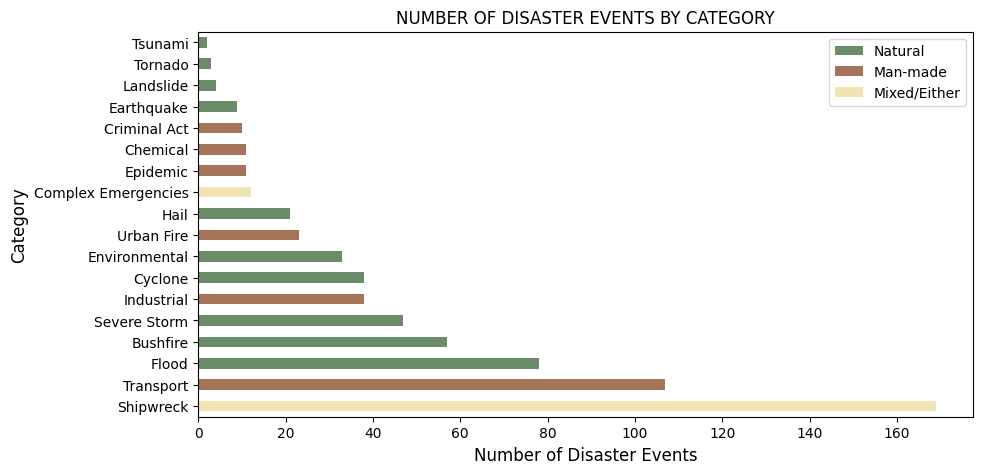

In [10]:
category_bar()

<i><b>Why might Shipwrecks be the top disaster event?</b></i><br>
Since the data tracks all the way back to the 1700s, at a time when transport by ship was most prominent (especially to and from Australia -- an island), it's more likely for records of ship movements and shipwrecks to be kept than of other disasters.


<i><b>Take home message from this graph:</b></i><br>
Our transport vehicles can certainly be safer.


<i><b>Why have I categorised 'Shipwrecks' and 'Complex Emergencies' as 'Mixed/Either'?</b></i><br><br>
The events under these two categories have varying causes. Some natural, some man-made, some a combination of both and some unknown.<br><br>
For example, some shipwrecks have been caused by severe storms, some have been caused by collisions, but most have unknown causes.

## Natural vs Man-made Disasters:

In [11]:
def cause_pie():
    disaster_data.cause.value_counts().plot.pie(autopct="%.1f%%", colors= ["#6A8C69", "#A67458", "#F2E3B3"])
    plt.title("DISTRIBUTION OF DISASTER EVENTS BY CAUSE", fontsize=12)
    plt.ylabel("", fontsize=15)
    plt.legend(bbox_to_anchor= (1.2, 1))

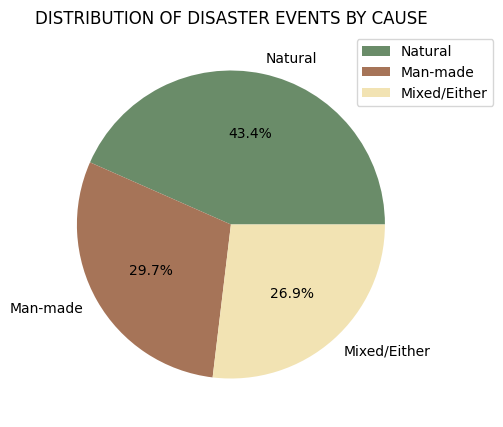

In [12]:
cause_pie()

There are more Natural Disasters than Man-made Disasters recorded in this data, but 'Mixed/Either' (which is mostly Shipwrecks) makes up quite a big chunk as well.

## Disaster Events by Location:

In [13]:
def region_pie():
    single_regions = disaster_data[disaster_data.regions.str.contains(";") == False]

    ddvc = single_regions.regions.value_counts() # This makes a series
    ddvc.plot(kind="pie", autopct="%.1f%%", cmap='Spectral')
    plt.title("DISTRIBUTION OF DISASTER EVENTS BY REGION", fontsize=12)
    plt.ylabel("", fontsize=15)
    plt.legend(bbox_to_anchor= (1.1, 1.1))

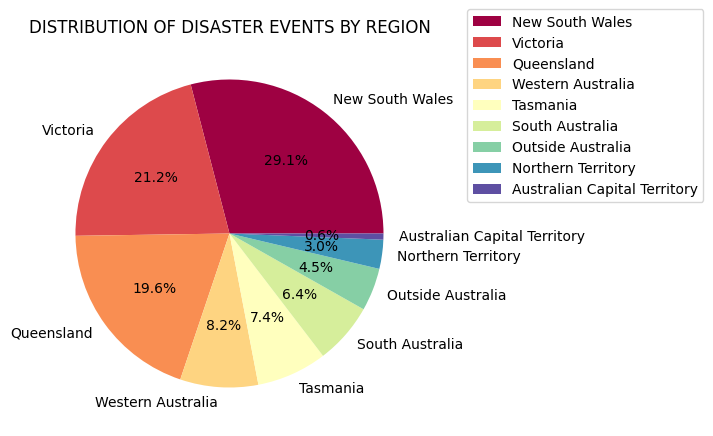

In [14]:
region_pie()

In [15]:
def population_pie():
    auspopdata = pd.DataFrame({"population": [8238800, 6704300, 5378300, 2825200, 1834300, 571600, 460900, 250100]}, index=["New South Wales", "Victoria", "Queensland", "Western Australia", "South Australia", "Tasmania", "Australian Capital Territory", "Northern Territory"])
    auspopdata.plot(kind="pie", y="population", autopct="%.1f%%", cmap='Spectral')
    plt.title("DISTRIBUTION OF POPULATION BY STATE", fontsize=12)
    plt.ylabel("", fontsize=15)
    plt.legend(bbox_to_anchor= (1.1, 1.1))

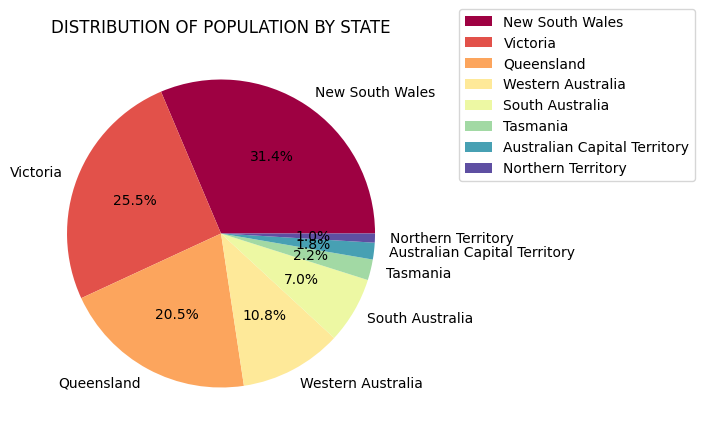

In [16]:
population_pie()

The distribution is quite proportional to the population of each state. This is expected because disasters need to affect people for them to be reported and oftentimes they are caused by people (i.e. man-made disasters).

Now to look at exactly where these disasters occurred...

In [17]:
gdf = gp.GeoDataFrame(disaster_data, geometry=gp.points_from_xy(disaster_data.lon, disaster_data.lat), crs="EPSG:4326"
)

cols_to_drop = ['FID', 'resourcetype', 'description', 'evacuated', 'homeless', 'injuries', 'deaths',
       'insured_cost', 'trains_damaged', 'trains_destroyed', 'homes_damaged',
       'homes_destroyed', 'buildings_damaged', 'buildings_destroyed',
       'ind_premises_destroyed', 'com_premises_damaged',
       'com_premises_destroyed', 'bridges_damaged', 'bridges_destroyed',
       'aircraft_damaged', 'aircraft_destroyed', 'motor_vehicles_damaged',
       'motor_vehicles_destroyed', 'water_vessels_damaged',
       'water_vessels_destroyed', 'businesses_damaged', 'businesses_destroyed',
       'farms_damaged', 'farms_destroyed', 'crops_destroyed',
       'livestock_destroyed', 'government_assistance', 'url', 'the_geom']
gdf.drop(cols_to_drop, axis=1, inplace=True, errors="ignore")
gdf

,id,title,startdate,enddate,lat,lon,regions,start_dt,end_dt,day_of_week,weekday_index,year,duration,duration_in_years,category,cause,geometry
0,3,Industrial - Appin Mine Explosion,1979-07-24,1979-07-24,-34.192211,150.786331,New South Wales,1979-07-24,1979-07-24,Tuesday,2,1979,0 days,0.000000,Industrial,Man-made,POINT (150.78633 -34.19221)
1,9,Transport - Trawalla Train and Truck Collision,2006-04-28,2006-04-28,-37.436260,143.469421,Victoria,2006-04-28,2006-04-28,Friday,5,2006,0 days,0.000000,Transport,Man-made,POINT (143.46942 -37.43626)
2,22,Bushfire - Great Divide Complex,2006-12-01,2007-02-07,-36.718010,147.145218,Victoria,2006-12-01,2007-02-07,Friday,5,2006,68 days,0.186301,Bushfire,Natural,POINT (147.14522 -36.71801)
3,24,Severe Storm - South-East Queensland and North...,2007-10-07,2007-10-12,-28.805798,153.276871,Queensland,2007-10-07,2007-10-12,Sunday,0,2007,5 days,0.013699,Severe Storm,Natural,POINT (153.27687 -28.80580)
4,38,Shipwreck - Vixen,1847-01-09,1847-01-09,-29.334297,153.369141,Queensland,1847-01-09,1847-01-09,Saturday,6,1847,0 days,0.000000,Shipwreck,Mixed/Either,POINT (153.36914 -29.33430)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,4946,"Bushfire - Grampians National Park, Victoria, ...",2014-01-15,2014-01-21,-37.129120,142.519623,Victoria,2014-01-15,2014-01-21,Wednesday,3,2014,6 days,0.016438,Bushfire,Natural,POINT (142.51962 -37.12912)
669,4960,"Environmental - Heatwave, South-Eastern Austra...",2014-01-11,2014-01-21,-33.284618,140.976562,Queensland;New South Wales;Victoria;South Aust...,2014-01-11,2014-01-21,Saturday,6,2014,10 days,0.027397,Environmental,Natural,POINT (140.97656 -33.28462)
670,5013,"Flood - Gascoyne River, Western Australia, 2010",2010-12-16,2010-12-20,-24.839088,113.749695,Queensland,2010-12-16,2010-12-20,Thursday,4,2010,4 days,0.010959,Flood,Natural,POINT (113.74969 -24.83909)
671,5015,"Bushfire - Victoria, 2014",2014-02-09,2014-02-14,-37.564716,144.893189,Victoria,2014-02-09,2014-02-14,Sunday,0,2014,5 days,0.013699,Bushfire,Natural,POINT (144.89319 -37.56472)


In [18]:
def global_map():
    countries = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
    ax = countries.plot(color="white", edgecolor="black")

    gdf.plot(ax=ax, column="category", cmap="tab20b", legend=True, legend_kwds={'bbox_to_anchor': (1.29, 1.03)})
    plt.title("LOCATION OF ALL DISASTER EVENTS INVOLVING AUSTRALIANS FROM 1753 TO 2014", fontsize=12)
    plt.ylabel("", fontsize=15)
    plt.grid()
    plt.show();

/tmp/ipykernel_21302/837662385.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))


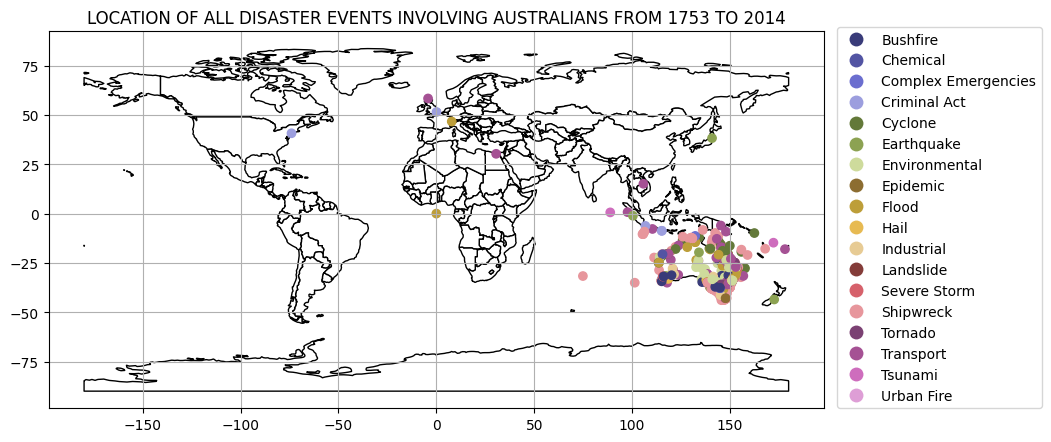

In [19]:
global_map()

<i><b>Observations:</b></i><br>
Some of these disasters took place outside of Australia but were included in the dataset because they involved/impacted Australians, typically travellers. Most of these seem to be close to Australia, located in and around South East Asia.


Let's take a closer look at Australia...

In [20]:
mid_of_aus = shapely.geometry.point.Point(134.298763, -25.002923)
gdf["distance_from_Aus"] = gdf.centroid.distance(mid_of_aus)
close_disasters = gdf[gdf.distance_from_Aus < 40]

/tmp/ipykernel_21302/1272217206.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["distance_from_Aus"] = gdf.centroid.distance(mid_of_aus)
/tmp/ipykernel_21302/1272217206.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["distance_from_Aus"] = gdf.centroid.distance(mid_of_aus)


In [21]:
def aus_map():
    countries = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
    ax = countries[countries["name"] == "Australia"].plot(color="white", edgecolor="black")

    close_disasters.plot(ax=ax, column="category", cmap="tab20b", legend=True, legend_kwds={'bbox_to_anchor': (1.35, 1)})
    plt.title("LOCATION OF DISASTER EVENTS IN AND AROUND AUSTRALIA FROM 1753 TO 2014", fontsize=12)
    plt.ylabel("", fontsize=15)
    plt.grid()
    plt.show();

/tmp/ipykernel_21302/1366990955.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))


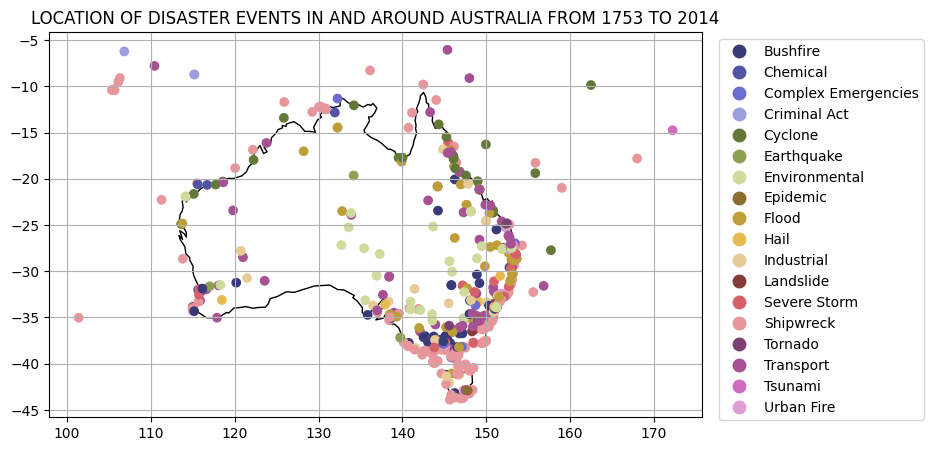

In [22]:
aus_map()

<i><b>Observations:</b></i>
* There are a greater number of events on the east and south-east side of Australia, typically along the coast.
* You can see shipwrecks mostly occurred off the coast of NSW, Victoria and Tasmania and in between. This was likely the most important  shipping route before planes for domestic transport since Tasmania is separated by sea. The other shipwrecks are assumingly near ports.
* As expected, cyclones are most common in tropical Queensland because of the climate.
* Most of the "Environmental" events away from the coast are heatwaves.

<i><b>What is going on in Alice Springs in the late 80s?</b></i><br><br>

<b>A flood in the middle of Australia:</b><br>
On 31 March 1988, the Todd River burst and flooded areas of Alice Springs. This resulted from the effects of two tropical depressions which caused large amounts of rainfall over a short duration. 300 people were evacuated and 3 people died.<br><br>

<b>A tragic hot air balloon crash:</b><br>
At dawn on 13 August 1989, two hot air balloons collided south of Alice Springs (one ascending and one descending). The one above struck the one below, tearing a hole that that caused the balloon to plummet to the ground, killing its driver and the 12 passengers on board.

In [23]:
def aus_map_cause():
    colours= {"Natural": "#6A8C69", "Man-made":"#A67458", "Mixed/Either": "#F2E3B3"}
    countries = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
    ax = countries[countries["name"] == "Australia"].plot(color="white", edgecolor="black")

    close_disasters.plot(ax=ax, column="cause", color=disaster_data['cause'].replace(colours), legend=True, legend_kwds={'bbox_to_anchor': (1.35, 1)})
    plt.legend([Patch(facecolor="#6A8C69"),Patch(facecolor="#A67458"),Patch(facecolor="#F2E3B3")], ["Natural", "Man-made", "Mixed/Either"])
    plt.title("LOCATION OF DISASTER EVENTS IN AND AROUND AUSTRALIA FROM 1753 TO 2014 BY CAUSE", fontsize=12)
    plt.ylabel("", fontsize=15)
    plt.show();

/tmp/ipykernel_21302/3516298736.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
/usr/local/python/3.10.8/lib/python3.10/site-packages/geopandas/plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


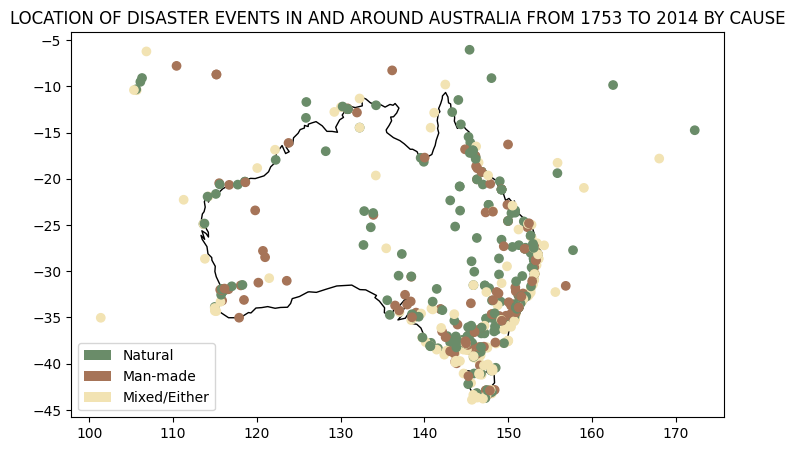

In [24]:
aus_map_cause()

<i><b>Observations:</b></i>
* Most man-made disasters are located near populated cities or along the coast as expected.
* Those further away from cities, like in Western Australia, are typically mining accidents or plane crashes.


## Disaster Events over Time:

In [25]:
def yearly_line():
    yearly_events = disaster_data.groupby("year").size()
    yearly_events.plot(kind="line", cmap='tab20b')

    plt.title("TOTAL NUMBER OF DISASTER EVENTS PER YEAR FROM 1753 TO 2014", fontsize=12)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Number of events", fontsize=12)
    plt.grid()
    plt.show();

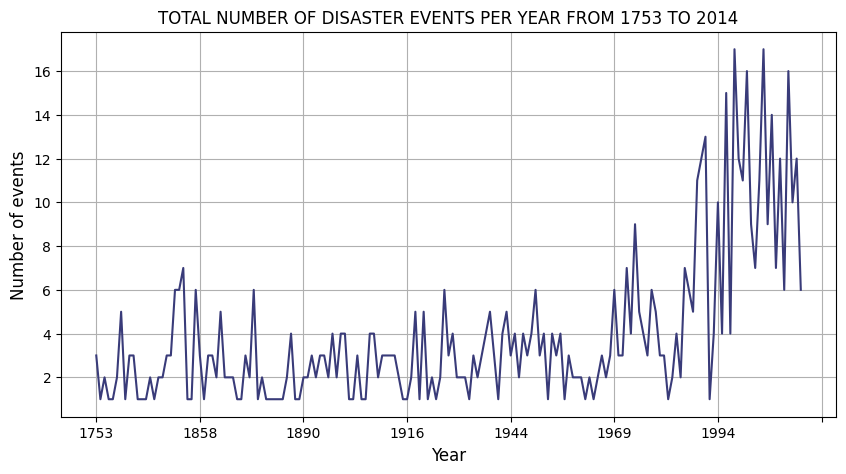

In [26]:
yearly_line()

* Number of events per year has increased significantly in recent years.
* This might just be because there's more records of events available in recent years compared to earlier years.
* Or it could be an indication of the effects of climate change.

Let's test this theory...

In [27]:
sliced_dd = disaster_data.set_index('start_dt').sort_index().loc['1900-01-01' : '2014-12-31', :] 
sliced_dd.head()

,FID,id,resourcetype,title,description,startdate,enddate,lat,lon,evacuated,...,url,the_geom,end_dt,day_of_week,weekday_index,year,duration,duration_in_years,category,cause
start_dt,,,,,,,,,,,,,,,,,,,,,
1900-01-19,disaster_events_impact_location.fid-2393c2e0_1...,194,Disaster Event,Epidemic - Bubonic Plague Sydney,"Between 1900 and 1925, there were 12 major pla...",1900-01-19,1925-01-01,-33.874977,151.215820,0.0,...,http://www.emknowledge.gov.au/resource/?id=194,POINT (-33.87497711 151.2158203),1925-01-01,Friday,5,1900,9113 days,24.967123,Epidemic,Man-made
1900-03-17,disaster_events_impact_location.fid-2393c2e0_1...,4415,Disaster Event,Industrial - Balmain Colliery 1900,"On 17 March 1900, six men were being lowered d...",1900-03-17,1900-03-17,-33.856731,151.181168,0.0,...,http://www.emknowledge.gov.au/resource/?id=4415,POINT (-33.85673141 151.1811676),1900-03-17,Saturday,6,1900,0 days,0.000000,Industrial,Man-made
1900-05-09,disaster_events_impact_location.fid-2393c2e0_1...,216,Disaster Event,Shipwreck - Sierra Nevada,The Sierra Nevada was an iron ship. It wrecked...,1900-05-09,1900-05-09,-38.335060,144.683929,0.0,...,http://www.emknowledge.gov.au/resource/?id=216,POINT (-38.33506012 144.6839294),1900-05-09,Wednesday,3,1900,0 days,0.000000,Shipwreck,Mixed/Either
1900-12-05,disaster_events_impact_location.fid-2393c2e0_1...,291,Disaster Event,Industrial - Greta Colliery Fire,"On 5 December 1900 at approximately 11 pm, a f...",1900-12-05,1900-12-05,-32.645157,151.390228,0.0,...,http://www.emknowledge.gov.au/resource/?id=291,POINT (-32.64515686 151.3902283),1900-12-05,Wednesday,3,1900,0 days,0.000000,Industrial,Man-made
1901-02-15,disaster_events_impact_location.fid-2393c2e0_1...,185,Disaster Event,Transport - Sydenham Train Derailment,"On 15 February 1901, a railway accident occurr...",1901-02-15,1901-02-15,-33.924034,151.156509,0.0,...,http://www.emknowledge.gov.au/resource/?id=185,POINT (-33.92403412 151.1565094),1901-02-15,Friday,5,1901,0 days,0.000000,Transport,Man-made


In [28]:
def yearly_line_natural():
    sliced_dd[sliced_dd.cause == "Natural"].groupby("year").size().plot(kind="line", color="#6A8C69")

    plt.title("TOTAL NUMBER OF NATURAL DISASTER EVENTS PER YEAR FROM 1900 TO 2014", fontsize=12)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Number of events", fontsize=12)
    plt.grid()
    plt.show();


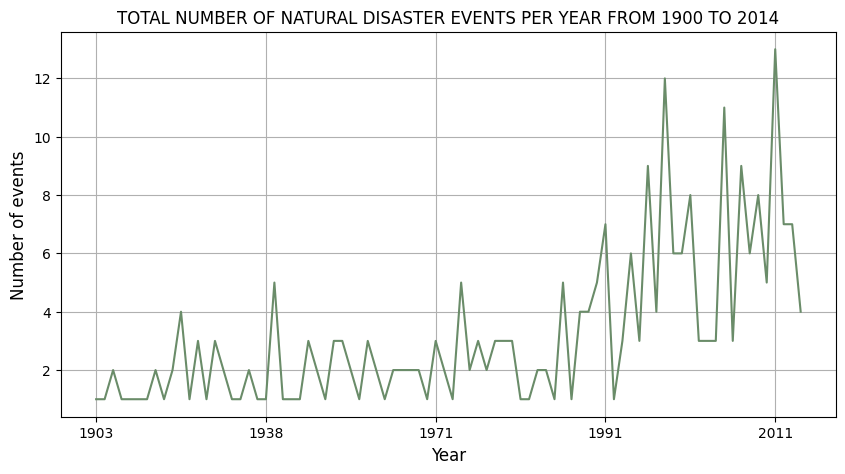

In [29]:
yearly_line_natural()

Looking at Natural Disaster Events after 1900 only, the increase in the number of events occuring per year is still pretty significant. 


The graph also shares a trend with global carbon emissions post-1900, so climate change is definitely playing a role:<br><br>
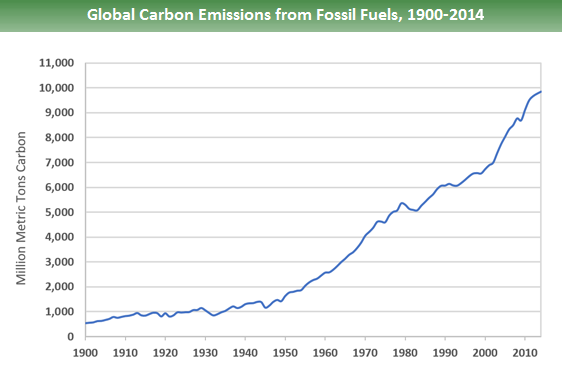
(source: EPA.gov)

In [30]:
def yearly_line_manmade():
    sliced_dd[sliced_dd.cause == "Man-made"].groupby("year").size().plot(kind="line", color="#A67458")

    plt.title("TOTAL NUMBER OF MAN-MADE DISASTER EVENTS PER YEAR FROM 1900 TO 2014", fontsize=12)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Number of events", fontsize=12)
    plt.grid()
    plt.show();

What about man-made disasters over time?

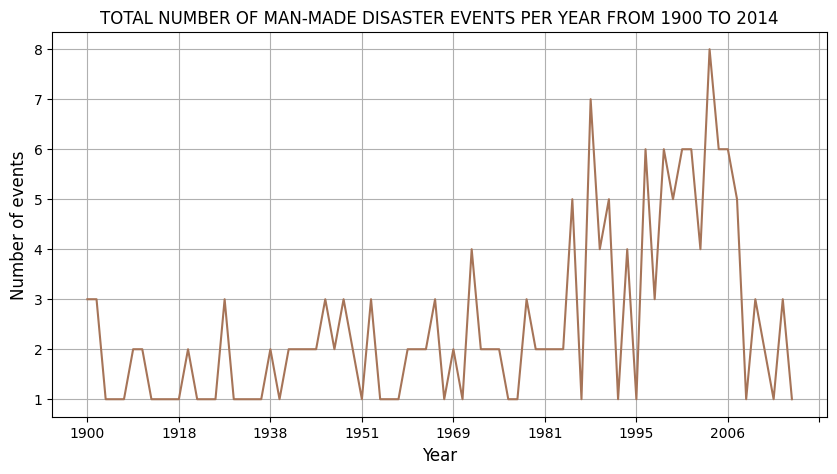

In [31]:
yearly_line_manmade()

There was a clear increase in man-made disaster events from the late 20th century to the early 2000s.
This is likely due to a rapid increase in air travel and vehicle usage which have caused more Transport disaster events.


In [32]:
def scatter():
    disaster_data[(disaster_data.deaths < 100) & (disaster_data.injuries < 100)].plot.scatter(x='deaths', y='injuries')

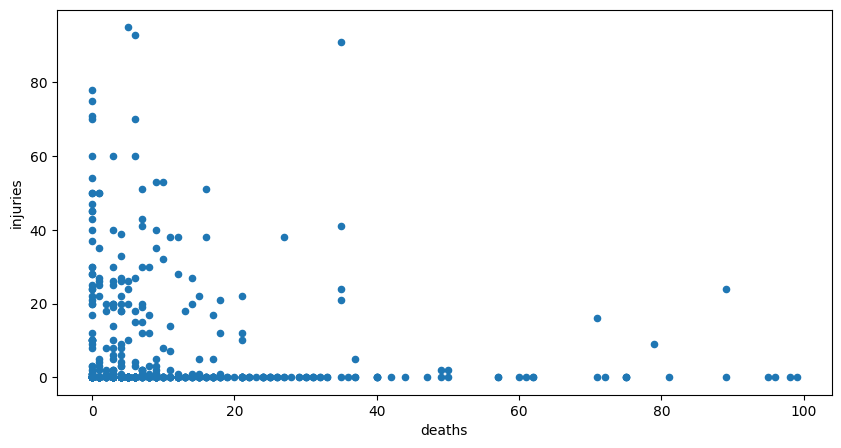

In [33]:
scatter()

## Disaster Events by Impact:

### Deaths

In [34]:
def deaths_bar():
    colours = ['#6A8C69', '#A67458', '#F2E3B3', '#A67458', '#6A8C69', '#6A8C69', '#6A8C69', '#A67458', '#6A8C69', '#6A8C69', '#A67458', '#6A8C69', '#6A8C69', '#F2E3B3', '#6A8C69', '#A67458', '#6A8C69', '#A67458']
    deaths = disaster_data.groupby(['category']).deaths.sum().plot(kind='barh', color=colours)
    plt.legend([Patch(facecolor="#6A8C69"),Patch(facecolor="#A67458"),Patch(facecolor="#F2E3B3")], ["Natural", "Man-made", "Mixed/Either"])
    plt.title("TOTAL DEATHS FROM DISASTER EVENTS BY CATEGORY", fontsize=12)
    plt.ylabel("Category", fontsize=12)
    plt.xlabel("Number of Deaths", fontsize=12)

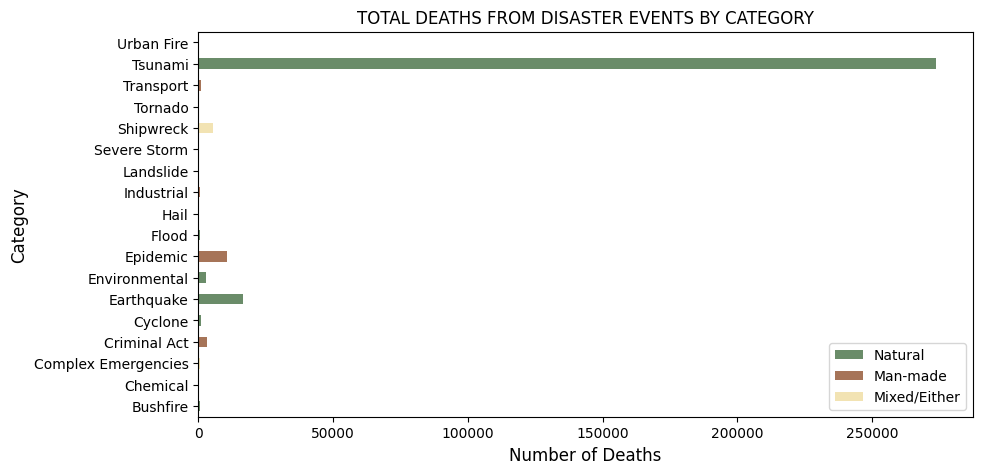

In [35]:
deaths_bar()

Why so many deaths from tsunamis?

<b>Top 5 events with the most deaths:</b>

In [36]:
top_deaths = disaster_data.sort_values('deaths', ascending=False).head(5)
top_deaths[['title','start_dt', 'deaths']]

,title,start_dt,deaths
411,Tsunami - Indian Ocean,2004-12-26,273636.0
526,Earthquake - Japan,2011-03-11,15467.0
138,Epidemic - Spanish Flu,1918-01-01,10000.0
419,Criminal Act - 9/11 Terrorist Attacks,2001-09-11,2819.0
505,Earthquake - Sumatra,2009-09-30,1117.0


After removing events with deaths greater than 5000...

In [37]:
def deaths_bar_short():
    colours = ['#6A8C69', '#A67458', '#F2E3B3', '#A67458', '#6A8C69', '#6A8C69', '#6A8C69', '#A67458', '#6A8C69', '#6A8C69', '#A67458', '#6A8C69', '#6A8C69', '#F2E3B3', '#6A8C69', '#A67458', '#6A8C69', '#A67458']
    deaths = disaster_data[(disaster_data.deaths < 5000)].groupby(['category']).deaths.sum().plot(kind='barh', color=colours)
    plt.legend([Patch(facecolor="#6A8C69"),Patch(facecolor="#A67458"),Patch(facecolor="#F2E3B3")], ["Natural", "Man-made", "Mixed/Either"])
    plt.title("TOTAL DEATHS FROM DISASTER EVENTS BY CATEGORY (DEATH TOLL UNDER 5000)", fontsize=12)
    plt.ylabel("Category", fontsize=12)
    plt.xlabel("Number of Deaths", fontsize=12)

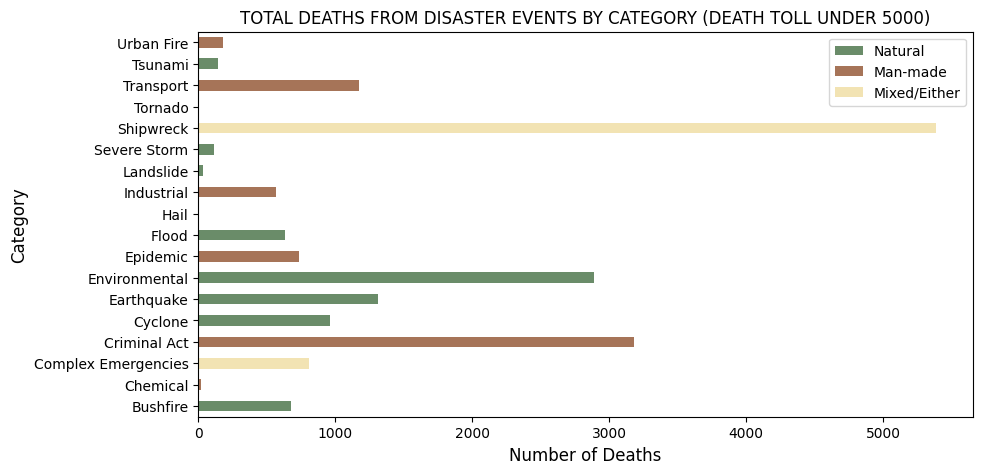

In [38]:
deaths_bar_short()

A summary:

In [39]:
def deaths_cause_pie():
    disaster_data.groupby(["cause"]).deaths.sum().plot(kind="pie", autopct="%.1f%%", colors= ["#A67458", "#F2E3B3", "#6A8C69"])
    plt.title("DISTRIBUTION OF DEATHS BY CAUSE", fontsize=12)
    plt.ylabel("", fontsize=15)
    plt.legend(bbox_to_anchor= (1.2, 1))

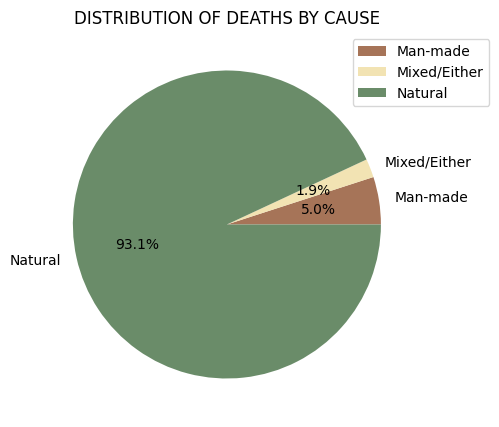

In [40]:
deaths_cause_pie()

### Injuries

In [41]:
def injuries_bar():
    colours = ['#6A8C69', '#A67458', '#F2E3B3', '#A67458', '#6A8C69', '#6A8C69', '#6A8C69', '#A67458', '#6A8C69', '#6A8C69', '#A67458', '#6A8C69', '#6A8C69', '#F2E3B3', '#6A8C69', '#A67458', '#6A8C69', '#A67458']
    injuries = disaster_data.groupby(['category']).injuries.sum().plot(kind='barh', color=colours)
    plt.legend([Patch(facecolor="#6A8C69"),Patch(facecolor="#A67458"),Patch(facecolor="#F2E3B3")], ["Natural", "Man-made", "Mixed/Either"])
    plt.title("TOTAL INJURIES FROM DISASTER EVENTS BY CATEGORY", fontsize=12)
    plt.ylabel("Category", fontsize=12)
    plt.xlabel("Number of Injuries", fontsize=12)

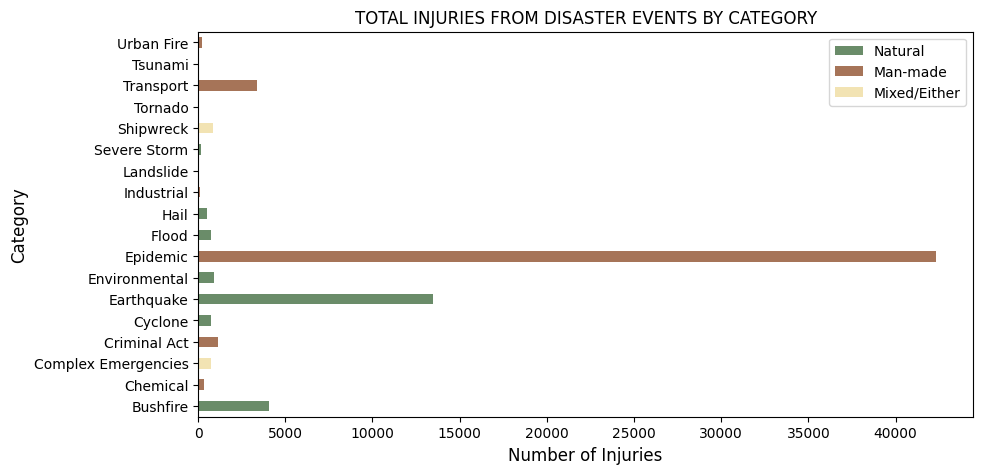

In [42]:
injuries_bar()

<b>Top 5 events with the most injuries:</b>

In [43]:
top_injuries = disaster_data.sort_values('injuries', ascending=False).head(5)
top_injuries[['title','start_dt', 'injuries']]

,title,start_dt,injuries
285,Epidemic - Poliomyelitis,1930-01-01,40000.0
628,"Earthquake - Christchurch, New Zealand",2011-02-22,6659.0
526,Earthquake - Japan,2011-03-11,5388.0
171,Bushfire - Ash Wednesday,1983-02-16,1500.0
2,Bushfire - Great Divide Complex,2006-12-01,1400.0


In [44]:
def injuries_bar_short():
    colours = ['#6A8C69', '#A67458', '#F2E3B3', '#A67458', '#6A8C69', '#6A8C69', '#6A8C69', '#A67458', '#6A8C69', '#6A8C69', '#A67458', '#6A8C69', '#6A8C69', '#F2E3B3', '#6A8C69', '#A67458', '#6A8C69', '#A67458']
    injuries = disaster_data[(disaster_data.injuries < 5000)].groupby(['category']).injuries.sum().plot(kind='barh', color=colours)
    plt.legend([Patch(facecolor="#6A8C69"),Patch(facecolor="#A67458"),Patch(facecolor="#F2E3B3")], ["Natural", "Man-made", "Mixed/Either"])
    plt.title("TOTAL INJURIES FROM DISASTER EVENTS BY CATEGORY (INJURY TOLL UNDER 5000)", fontsize=12)
    plt.ylabel("Category", fontsize=12)
    plt.xlabel("Number of Injuries", fontsize=12)

After removing events with injuries greater than 5000...

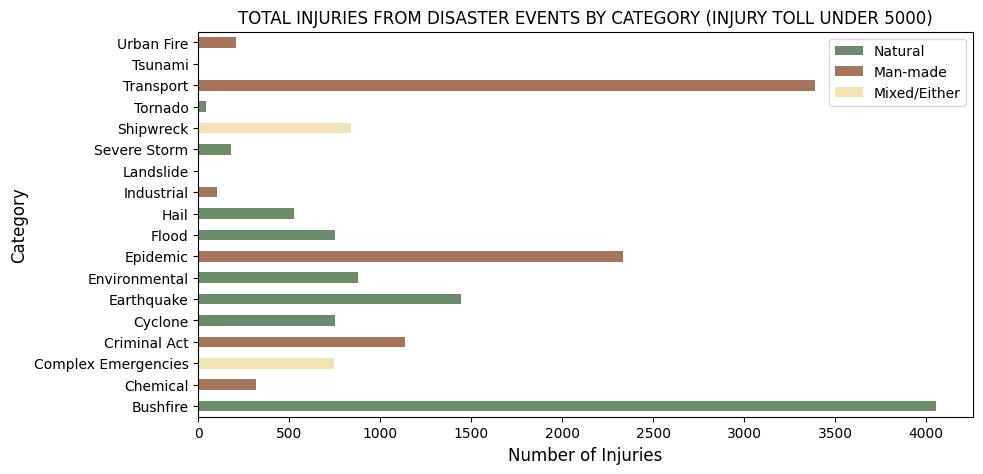

In [45]:
injuries_bar_short()

A summary:

In [46]:
def injuries_cause_pie():
    disaster_data.groupby(["cause"]).injuries.sum().plot(kind="pie", autopct="%.1f%%", colors= ["#A67458", "#F2E3B3", "#6A8C69"])
    plt.title("DISTRIBUTION OF INJURIES BY CAUSE", fontsize=12)
    plt.ylabel("", fontsize=15)
    plt.legend(bbox_to_anchor= (1.2, 1))

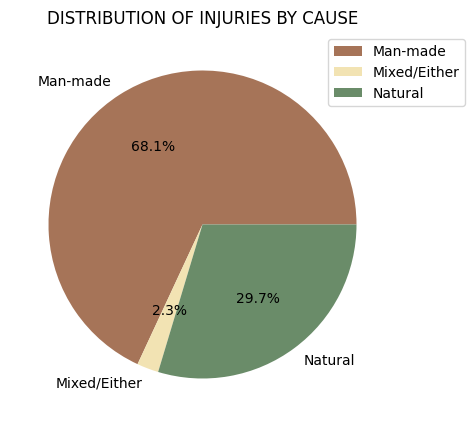

In [47]:
injuries_cause_pie()

### Insured Cost

In [48]:
def divide_by_mill(raw_cost):
    return int(raw_cost)/1000000

def avg_cost_bar():
    disaster_data["insured_cost_mill"] = disaster_data.insured_cost.apply(divide_by_mill)
    colours = ['#6A8C69', '#A67458', '#F2E3B3', '#A67458', '#6A8C69', '#6A8C69', '#6A8C69', '#A67458', '#6A8C69', '#6A8C69', '#A67458', '#6A8C69', '#6A8C69', '#F2E3B3', '#6A8C69', '#A67458', '#6A8C69', '#A67458']
    injuries = disaster_data.groupby(['category']).insured_cost_mill.mean().plot(kind='bar', color=colours)
    plt.legend([Patch(facecolor="#6A8C69"),Patch(facecolor="#A67458"),Patch(facecolor="#F2E3B3")], ["Natural", "Man-made", "Mixed/Either"])
    plt.title("AVERAGE INSURED COST OF DISASTER EVENTS BY CATEGORY", fontsize=12)
    plt.xlabel("Category", fontsize=12)
    plt.ylabel("Average Insured Cost (million) ($)", fontsize=12)

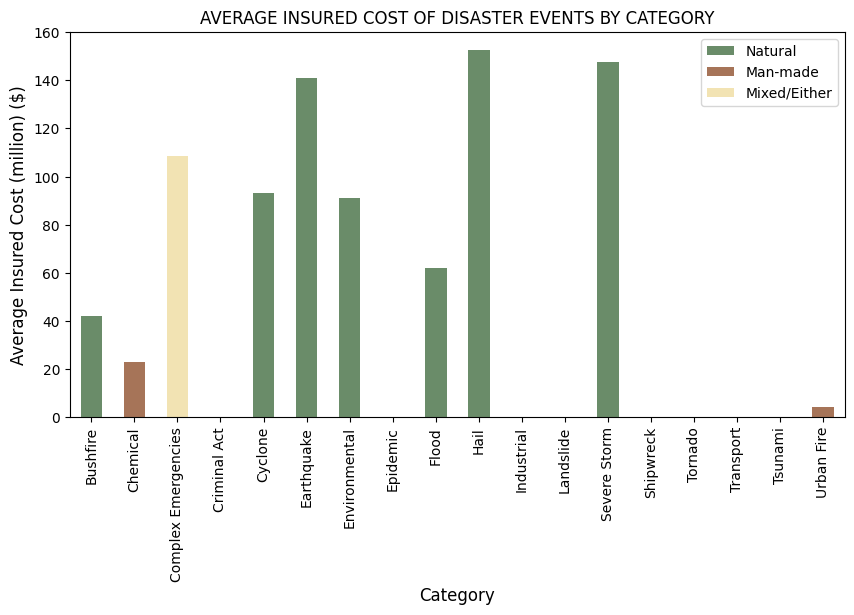

In [49]:
avg_cost_bar()

These are mostly natural disasters. This makes sense since they can't be controlled and you can't blame anyone so damages need to be covered by the government rather than individuals.

<b>Top 5 Most Costly Disaster Events:</b>

In [50]:
top_cost = disaster_data.sort_values('insured_cost_mill', ascending=False).head(5)
top_cost[['title','start_dt', 'insured_cost_mill']]

,title,start_dt,insured_cost_mill
136,Environmental - Eastern Australia Drought,1982-04-01,3000.0
29,Flood - Queensland Nov 2010,2010-11-30,2380.0
249,Hail - Sydney Apr 1999,1999-04-14,1700.0
63,Severe Storm - New South Wales East Coast Low,2007-06-08,1480.0
519,"Cyclone Yasi, Queensland, 2011",2011-02-03,1412.0


## Disaster Events by Duration:

<b>Top 5 Longest Disaster Events:</b>

In [51]:
top_longest = disaster_data.sort_values('duration', ascending=False)
top_longest[['title', 'start_dt', 'end_dt', 'duration', "duration_in_years"]].head()

,title,start_dt,end_dt,duration,duration_in_years
285,Epidemic - Poliomyelitis,1930-01-01,1959-01-01,10592 days,29.019178
230,Epidemic - Bubonic Plague Sydney,1900-01-19,1925-01-01,9113 days,24.967123
45,Environmental - The Big Dry,1996-01-01,2012-04-01,5935 days,16.260274
351,Environmental - National Drought,1958-01-01,1968-09-01,3896 days,10.673973
309,Environmental - Federation Drought,1895-01-01,1902-01-01,2556 days,7.002740


In [52]:
def longest_disasters():
    colours = ['#A67458', '#A67458', '#6A8C69', '#6A8C69', '#6A8C69']
    top_longest.index = top_longest.title
    top_longest.head().duration_in_years.plot.barh(color=colours, use_index=True)
    plt.legend([Patch(facecolor="#6A8C69"),Patch(facecolor="#A67458")], ["Natural", "Man-made"])
    plt.title("TOP 5 LONGEST DISASTER EVENTS", fontsize=12)
    plt.ylabel("Event", fontsize=12)
    plt.xlabel("Duration (years)", fontsize=12)

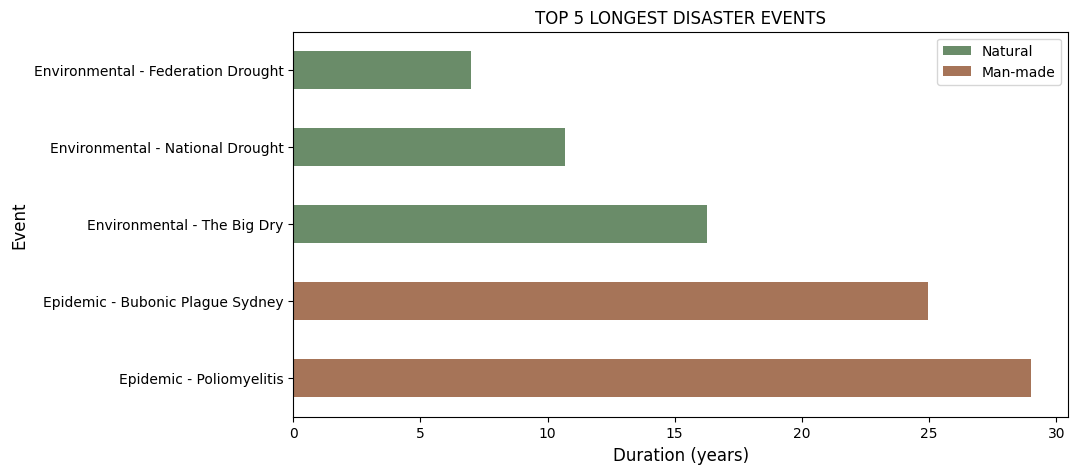

In [53]:
longest_disasters()

## Disaster Events by Day of the Week:

Are man-made disasters caused on certain days of the week more than other days?

In [54]:
def day_of_week_category():
    fig, axes = plt.subplots(nrows=2, ncols=3)

    ax1 = disaster_data[disaster_data.category == "Transport"].day_of_week.value_counts().plot(kind="bar", color="#A67458", ax=axes[0,0])
    ax2 = disaster_data[disaster_data.category == "Chemical"].day_of_week.value_counts().plot(kind="bar", color="#A67458", ax=axes[0,1])
    ax3 = disaster_data[disaster_data.category == "Criminal Act"].day_of_week.value_counts().plot(kind="bar", color="#A67458", ax=axes[0,2])
    ax4 = disaster_data[disaster_data.category == "Epidemic"].day_of_week.value_counts().plot(kind="bar", color="#A67458", ax=axes[1,0])
    ax5 = disaster_data[disaster_data.category == "Industrial"].day_of_week.value_counts().plot(kind="bar", color="#A67458", ax=axes[1,1])
    ax6 = disaster_data[disaster_data.category == "Urban Fire"].day_of_week.value_counts().plot(kind="bar", color="#A67458", ax=axes[1,2])

    ax1.title.set_text('TRANSPORT')
    ax1.set_xlabel("Day of the Week")
    ax1.set_ylabel("No. of Events")
    ax2.title.set_text('CHEMICAL')
    ax2.set_xlabel("Day of the Week")
    ax2.set_ylabel("No. of Events")
    ax3.title.set_text('CRIMINAL ACT')
    ax3.set_xlabel("Day of the Week")
    ax3.set_ylabel("No. of Events")
    ax4.title.set_text('EPIDEMIC')
    ax4.set_xlabel("Day of the Week")
    ax4.set_ylabel("No. of Events")
    ax5.title.set_text('INDUSTRIAL')
    ax5.set_xlabel("Day of the Week")
    ax5.set_ylabel("No. of Events")
    ax6.title.set_text('URBAN FIRE')
    ax6.set_xlabel("Day of the Week")
    ax6.set_ylabel("No. of Events")

    fig.tight_layout()
    plt.show()

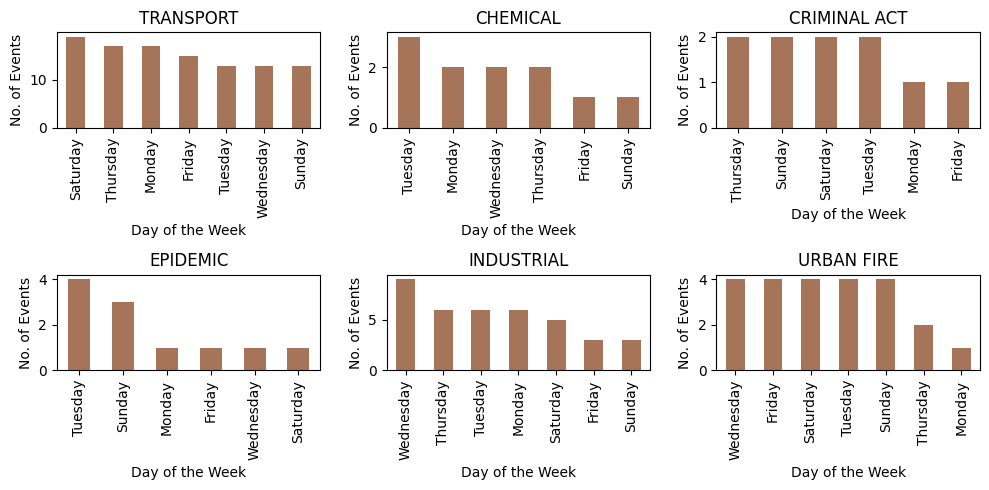

In [55]:
day_of_week_category()

<i><b>Observations:</b></i>
* Epidemics seem to start on a Tuesday more often than any other day.
* If I was a miner, I would avoid going to work on a Wednesday.
* No criminal acts have been conducted on a Wednesday (yet).


A summary:

In [56]:
def day_of_week_pie():
    disaster_data[disaster_data.cause == "Man-made"].day_of_week.value_counts().plot(kind="pie", cmap="Spectral")
    plt.title("DISTRIBUTION OF MAN-MADE DISASTER EVENTS BY DAYS OF THE WEEK", fontsize=12)
    plt.ylabel("", fontsize=15)
    plt.legend(bbox_to_anchor= (1.1, 1))

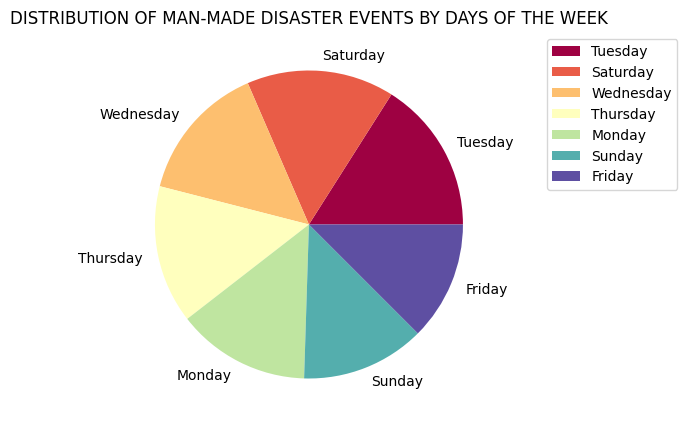

In [57]:
day_of_week_pie()

Pretty even distribution overall.

### All done!
### Thanks for listening :)